# RFP: Maze Solvers

## Project Overview
You are invited to submit a proposal that answers the following question:

### What path will your elf take?

*Please submit your proposal by **2/11/25 at 11:59 PM**.*

## Required Proposal Components

### 1. Data Description
In the code cell below, use [Gymnasium](https://gymnasium.farama.org/) to set up a [Frozen Lake maze](https://gymnasium.farama.org/environments/toy_text/frozen_lake/) for your project. When you are done with the set up, describe the reward system you plan on using.

*Note, a level 5 maze is at least 10 x 10 cells large and contains at least five lake cells.*

In [50]:
# !pip install "gymnasium[toy-text]"

In [85]:
import gymnasium as gym
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import imageio

# Define a custom 10x10 Frozen Lake map with an elf navigating
lake_map = [
    "SFFFFFFFFF",
    "FFFFFFFFFH",
    "FFFHFFFFFF",
    "FFFFFFHFFF",
    "FFHFFFFFFF",
    "FFFFFFFHFF",
    "HFFFFFFHFF",
    "FFFHFFFFFH",
    "FFFFFFHFFF",
    "FFFFFFFGFH"  # Goal 'G' at (9,7)
]

# Create the Frozen Lake environment with visualization
env = gym.make("FrozenLake-v1", desc=lake_map, is_slippery=True, render_mode="rgb_array")

# Reset environment to initialize display
state, _ = env.reset()

# Initialize Q-table
state_size = env.observation_space.n
action_size = env.action_space.n
q_table = np.zeros((state_size, action_size))

# Hyperparameters
learning_rate = 0.1
discount_factor = 0.99
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.995
min_epsilon = 0.01
num_episodes = 1000

# Custom reward system
reward_mapping = {"goal": 1, "hole": -1, "step": -0.01}

In [87]:
env.close()

#### The reward system helps the AI learn the best path through the Frozen Lake maze. It gets +1 point for reaching the goal, -1 point for falling into a hole, and -0.01 points for every step to prevent wandering. This teaches the AI to be efficient, avoid risks, and find the shortest, safest route to the goal. Over time, it learns to make smarter moves and navigate the maze effectively.

### 2. Training Your Model
In the cell seen below, write the code you need to train a Q-Learning model. Display your final Q-table once you are done training your model.

*Note, level 5 work uses only the standard Python library and Pandas to train your Q-Learning model. A level 4 uses external libraries like Baseline3.*

In [91]:
# Q-learning algorithm
for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    
    while not done:
        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(q_table[state, :])  # Exploit best known action
        
        new_state, reward, terminated, truncated, _ = env.step(action)
        
        # Adjust reward based on custom reward mapping
        if terminated and reward == 1:
            reward = reward_mapping["goal"]
        elif terminated:
            reward = reward_mapping["hole"]
        else:
            reward = reward_mapping["step"]
        
        # Update Q-value
        q_table[state, action] = q_table[state, action] + learning_rate * (
            reward + discount_factor * np.max(q_table[new_state, :]) - q_table[state, action]
        )
        
        state = new_state
        done = terminated or truncated
    
    epsilon = max(min_epsilon, epsilon * epsilon_decay)  # Decay exploration rate

# Display final Q-table
q_table_df = pd.DataFrame(q_table, columns=["Left", "Down", "Right", "Up"])
print("Final Q-table:")
print(q_table_df)

Final Q-table:
        Left      Down     Right        Up
0  -0.289065 -0.287737 -0.288704 -0.288650
1  -0.280461 -0.279277 -0.277987 -0.280130
2  -0.265921 -0.265272 -0.265168 -0.265778
3  -0.245407 -0.245301 -0.242555 -0.244890
4  -0.230072 -0.228901 -0.228416 -0.228032
..       ...       ...       ...       ...
95  0.175592  0.674405  0.187580  0.061635
96 -0.113918  0.867349 -0.246675  0.074938
97  0.000000  0.000000  0.000000  0.000000
98  0.706635  0.007038 -0.100000  0.000000
99  0.000000  0.000000  0.000000  0.000000

[100 rows x 4 columns]


### 3. Testing Your Model
In the cell seen below, write the code you need to test your Q-Learning model for **1000 episodes**. It is important to test your model for 1000 episodes so that we are all able to compare our results.

*Note, level 5 testing uses both a success rate and an average steps taken metric to evaluate your model. Level 4 uses one or the other.*

In [93]:
# Testing the trained model
test_episodes = 1000
success_count = 0
step_counts = []

for _ in range(test_episodes):
    state, _ = env.reset()
    done = False
    steps = 0
    
    while not done:
        action = np.argmax(q_table[state, :])  # Always exploit the best known action
        new_state, reward, terminated, truncated, _ = env.step(action)
        
        steps += 1
        state = new_state
        done = terminated or truncated
        
        if terminated and reward == 1:
            success_count += 1
    
    step_counts.append(steps)

success_rate = success_count / test_episodes
average_steps = np.mean(step_counts)

print(f"Success Rate: {success_rate * 100:.2f}%")
print(f"Average Steps Taken: {average_steps:.2f}")

Success Rate: 54.80%
Average Steps Taken: 81.74


### 4. Final Answer
In the first cell below, describe the path your elf takes to get to the gift. *Note, a level 5 answer includes a gif of the path your elf takes in order to reach the gift.*

In the second cell seen below, describe how well your Q-Learning model performed. Make sure that you explicitly name the **learning rate**, **the discount factor**, and the **reward system** that you used when training your final model. *Note, a level 5 description describes the model's performance using two types of quantitative evidence.*

In [95]:
# Simulate and render the fastest path
def simulate_fastest_path(env, q_table):
    state, _ = env.reset()
    done = False
    frames = []
    
    while not done:
        frame = env.render()
        frames.append(frame)  # Ensure frames are correctly stored as RGB arrays
        action = np.argmax(q_table[state, :])  # Always exploit the best known action
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
    
    env.close()
    return np.array(frames, dtype=np.uint8)  # Ensure frames are proper image format
# Save the path as a gif
frames = simulate_fastest_path(env, q_table)

# Save the path as a gif
def save_gif(frames, filename="elf_path.gif"):
    with imageio.get_writer(filename, mode='I', duration=0.3) as writer:
        for frame in frames:
            writer.append_data(frame)
    print(f"GIF saved as {filename}")

save_gif(frames)

GIF saved as elf_path.gif


GIF saved as elf_path.gif


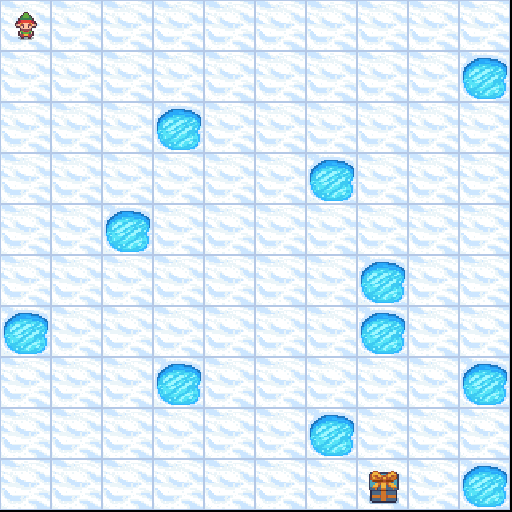

In [96]:
import os
if os.path.exists("elf_path.gif"):
    os.remove("elf_path.gif")
save_gif(frames)

# Display the updated gif
display(Image(filename="elf_path.gif"))


![example image](https://gymnasium.farama.org/_images/frozen_lake.gif)

#### Describe the path your elf takes here.

#### Describe how well your Q-Learning model performed here.